In [1]:
import sys
sys.executable

'/usr/bin/python3'

In [2]:
! pip install datasets pillow pandas tqdm

In [3]:
## STEP 1: IMPORTS AND CONFIGURATION

import os
import json
from datasets import load_dataset
from PIL import Image
from collections import defaultdict
from tqdm import tqdm
import random

In [4]:
["person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
# 25 Selected Classes (COCO category IDs)

SELECTED_CLASSES = {
    'person':0,
    'bicycle': 1,
    'car': 2,
    'motorcycle': 3,
    'airplane': 4,
    'bus': 5,
    'truck': 7,
    'traffic light': 9,
    'stop sign': 11,
    'bench': 13,
    'bird': 14,
    'cat': 15,
    'dog': 16,
    'horse': 17,
    'cow': 19,
    'elephant': 20,
    'bottle': 39,
    'cup': 41,
    'bowl': 45,
    'pizza': 53,
    'cake': 55,
    'chair': 56,
    'couch': 57,
    'bed': 59,
    'potted plant': 58
}

IMAGES_PER_CLASS = 100
BASE_DIR = "smartvision_dataset"

In [6]:
## STEP 2: LOAD COCO DATASET FROM HUGGING FACE

print("📥 Loading COCO dataset in STREAMING mode (no download)...")
dataset = load_dataset("detection-datasets/coco", split="train", streaming=True)
print("✅ Dataset loaded in streaming mode!")

📥 Loading COCO dataset in STREAMING mode (no download)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

✅ Dataset loaded in streaming mode!


In [7]:
## STEP 3: COLLECT IMAGES FROM STREAM

print("\n🔍 Starting image collection from COCO dataset stream...")
print(f"🎯 Target: {IMAGES_PER_CLASS} images per class")
print()

# Initialize storage for collected images
class_images = {class_name: [] for class_name in SELECTED_CLASSES.keys()}
class_counts = {class_name: 0 for class_name in SELECTED_CLASSES.keys()}

# Progress tracking
total_collected = 0
images_processed = 0
max_iterations = 50000  # Safety limit

print("⏳ Processing images from stream...")
print("💡 Progress updates every 100 images collected")
print()

# Iterate through streaming dataset
for idx, item in enumerate(dataset):

    images_processed += 1

    # Progress update every 1000 images processed
    if images_processed % 1000 == 0:
        print(f"📊 Processed {images_processed} images | Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS}")

    # Safety check
    if images_processed >= max_iterations:
        print(f"⚠️ Reached safety limit of {max_iterations} iterations")
        break

    # Check if we have enough images for ALL classes
    if all(count >= IMAGES_PER_CLASS for count in class_counts.values()):
        print("🎉 Successfully collected 100 images for ALL classes!")
        break

    # Get annotations from current image
    annotations = item['objects']
    categories = annotations['category']

    # Check if any of our target classes are in this image
    for cat_id in categories:
        for class_name, class_id in SELECTED_CLASSES.items():
            if cat_id == class_id and class_counts[class_name] < IMAGES_PER_CLASS:

                # Store the ACTUAL image data (not just index!)
                class_images[class_name].append({
                    'image': item['image'],           # PIL Image object
                    'annotations': item['objects'],   # Annotations
                    'idx': images_processed           # For naming
                })

                class_counts[class_name] += 1
                total_collected += 1

                # Progress update every 100 collected
                if total_collected % 100 == 0:
                    print(f"✓ Collected {total_collected}/{len(SELECTED_CLASSES) * IMAGES_PER_CLASS} images")

                break  # Only count once per class

print()
print("="*60)
print("📊 COLLECTION COMPLETE:")
print("="*60)
print(f"Images Processed: {images_processed}")
print(f"Images Collected: {total_collected}")
print()
for class_name, count in sorted(class_counts.items()):
    status = "✅" if count >= IMAGES_PER_CLASS else "⚠️"
    print(f"{status} {class_name:20s}: {count:3d} images")
print("="*60)


🔍 Starting image collection from COCO dataset stream...
🎯 Target: 100 images per class

⏳ Processing images from stream...
💡 Progress updates every 100 images collected

✓ Collected 100/2500 images
✓ Collected 200/2500 images
✓ Collected 300/2500 images
✓ Collected 400/2500 images
✓ Collected 500/2500 images
✓ Collected 600/2500 images
✓ Collected 700/2500 images
✓ Collected 800/2500 images
✓ Collected 900/2500 images
✓ Collected 1000/2500 images
✓ Collected 1100/2500 images
✓ Collected 1200/2500 images
✓ Collected 1300/2500 images
✓ Collected 1400/2500 images
✓ Collected 1500/2500 images
✓ Collected 1600/2500 images
📊 Processed 1000 images | Collected 1642/2500
✓ Collected 1700/2500 images
✓ Collected 1800/2500 images
✓ Collected 1900/2500 images
✓ Collected 2000/2500 images
✓ Collected 2100/2500 images
✓ Collected 2200/2500 images
📊 Processed 2000 images | Collected 2273/2500
✓ Collected 2300/2500 images
✓ Collected 2400/2500 images
📊 Processed 3000 images | Collected 2443/2500
📊 Pr

In [8]:
## STEP 4: CREATE FOLDER STRUCTURE

print("\n📁 Creating project folder structure...")
print()

# Create main directory
os.makedirs(BASE_DIR, exist_ok=True)

# Create subdirectories for Classification task
os.makedirs(f"{BASE_DIR}/classification/train", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/val", exist_ok=True)
os.makedirs(f"{BASE_DIR}/classification/test", exist_ok=True)

# Create subdirectories for Detection task
os.makedirs(f"{BASE_DIR}/detection/images", exist_ok=True)
os.makedirs(f"{BASE_DIR}/detection/labels", exist_ok=True)

# Create class folders inside train/val/test
for class_name in SELECTED_CLASSES.keys():
    os.makedirs(f"{BASE_DIR}/classification/train/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/val/{class_name}", exist_ok=True)
    os.makedirs(f"{BASE_DIR}/classification/test/{class_name}", exist_ok=True)

print("✅ Folder structure created successfully!")
print()
print("📂 Structure:")
print(f"""
{BASE_DIR}/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/
""")


📁 Creating project folder structure...

✅ Folder structure created successfully!

📂 Structure:

smartvision_dataset/
├── classification/
│   ├── train/
│   │   ├── person/
│   │   ├── car/
│   │   └── ... (25 class folders)
│   ├── val/
│   │   └── ... (25 class folders)
│   └── test/
│       └── ... (25 class folders)
│
└── detection/
    ├── images/
    └── labels/



In [9]:
## STEP 5: TRAIN/VAL/TEST SPLIT (70/15/15)

print("="*70)
print("🔀 Preparing Train/Val/Test splits...")
print("📊 Split Ratio: 70% Train / 15% Val / 15% Test")
print("="*70)
print()

# Initialize metadata dictionary
metadata = {
    'total_images': 0,
    'classes': {},
    'splits': {'train': 0, 'val': 0, 'test': 0}
}

# Create split dictionaries for each class
train_data = {}
val_data = {}
test_data = {}

# Process each class
for class_name in SELECTED_CLASSES.keys():

    all_items = class_images.get(class_name, [])

    if not all_items:
        print(f"⚠️ Warning: No images found for {class_name}")
        continue

    # Calculate split indices
    n = len(all_items)
    train_split = int(0.7 * n)   # 70% for training
    val_split = int(0.85 * n)    # 15% for validation
    # Remaining 15% for test

    # Split the data
    train_data[class_name] = all_items[:train_split]
    val_data[class_name] = all_items[train_split:val_split]
    test_data[class_name] = all_items[val_split:]

    # Store split info in metadata
    metadata['classes'][class_name] = {
        'train': len(train_data[class_name]),
        'val': len(val_data[class_name]),
        'test': len(test_data[class_name]),
        'total': len(all_items)
    }

    metadata['splits']['train'] += len(train_data[class_name])
    metadata['splits']['val'] += len(val_data[class_name])
    metadata['splits']['test'] += len(test_data[class_name])
    metadata['total_images'] += len(all_items)

    print(f"{class_name:20s}: Train={len(train_data[class_name]):3d} | Val={len(val_data[class_name]):2d} | Test={len(test_data[class_name]):2d}")

🔀 Preparing Train/Val/Test splits...
📊 Split Ratio: 70% Train / 15% Val / 15% Test

person              : Train= 70 | Val=15 | Test=15
bicycle             : Train= 70 | Val=15 | Test=15
car                 : Train= 70 | Val=15 | Test=15
motorcycle          : Train= 70 | Val=15 | Test=15
airplane            : Train= 70 | Val=15 | Test=15
bus                 : Train= 70 | Val=15 | Test=15
truck               : Train= 70 | Val=15 | Test=15
traffic light       : Train= 70 | Val=15 | Test=15
stop sign           : Train= 70 | Val=15 | Test=15
bench               : Train= 70 | Val=15 | Test=15
bird                : Train= 70 | Val=15 | Test=15
cat                 : Train= 70 | Val=15 | Test=15
dog                 : Train= 70 | Val=15 | Test=15
horse               : Train= 70 | Val=15 | Test=15
cow                 : Train= 70 | Val=15 | Test=15
elephant            : Train= 70 | Val=15 | Test=15
bottle              : Train= 70 | Val=15 | Test=15
cup                 : Train= 70 | Val=15 | Test=1

In [10]:
import os
from PIL import Image
from tqdm import tqdm
import json

print("="*70)
print("💾 STEP 6: SAVING IMAGES TO DISK")
print("="*70)
print()

# PART A: SAVE CLASSIFICATION IMAGES


print("📁 PART A: Saving Classification Images...")
print("   Format: Cropped objects, 224x224 pixels\n")

classification_stats = {'train': 0, 'val': 0, 'test': 0}

# Process each split
for split_name, split_data in [('train', train_data), ('val', val_data), ('test', test_data)]:

    print(f"📂 Processing {split_name.upper()} split...")

    # Process each class
    for class_name, items in tqdm(split_data.items(), desc=f"  {split_name}"):

        class_folder = f"{BASE_DIR}/classification/{split_name}/{class_name}"

        # Save each image
        for img_idx, item in enumerate(items):

            img = item['image']
            annotations = item['annotations']
            bboxes = annotations['bbox']
            categories = annotations['category']

            class_id = SELECTED_CLASSES[class_name]

            # Find bbox for this class
            for bbox, cat_id in zip(bboxes, categories):
                if cat_id == class_id:
                    x, y, w, h = bbox

                    try:
                        # Crop and resize
                        cropped_img = img.crop((x, y, x + w, y + h))
                        cropped_img = cropped_img.resize((224, 224), Image.LANCZOS)

                        # Save
                        img_filename = f"{class_name}_{split_name}_{img_idx:04d}.jpg"
                        img_path = os.path.join(class_folder, img_filename)
                        cropped_img.save(img_path, quality=95)

                        classification_stats[split_name] += 1

                    except Exception as e:
                        print(f"⚠️ Error: {class_name} image {img_idx}: {e}")

                    break

print()
print("="*70)
print("✅ CLASSIFICATION IMAGES SAVED!")
print("="*70)
print(f"📊 Train: {classification_stats['train']} images")
print(f"📊 Val:   {classification_stats['val']} images")
print(f"📊 Test:  {classification_stats['test']} images")
print(f"📊 Total: {sum(classification_stats.values())} images")
print()

💾 STEP 6: SAVING IMAGES TO DISK

📁 PART A: Saving Classification Images...
   Format: Cropped objects, 224x224 pixels

📂 Processing TRAIN split...


  train:   0%|          | 0/25 [00:00<?, ?it/s]

  train: 100%|██████████| 25/25 [00:05<00:00,  4.61it/s]


📂 Processing VAL split...


  val: 100%|██████████| 25/25 [00:01<00:00, 21.01it/s]


📂 Processing TEST split...


  test: 100%|██████████| 25/25 [00:01<00:00, 21.06it/s]


✅ CLASSIFICATION IMAGES SAVED!
📊 Train: 1750 images
📊 Val:   375 images
📊 Test:  375 images
📊 Total: 2500 images



In [11]:
# PART B: SAVE DETECTION IMAGES (YOLO FORMAT)

print("="*70)
print("📁 PART B: Saving Detection Images & Annotations...")
print("   Format: Full images with YOLO .txt labels\n")

detection_stats = {'images': 0, 'annotations': 0, 'objects': 0}

# COCO to YOLO class mapping
coco_to_yolo = {class_id: idx for idx, class_id in enumerate(SELECTED_CLASSES.values())}

# Combine train + val for detection
all_detection_data = []
for class_name in SELECTED_CLASSES.keys():
    all_detection_data.extend(train_data.get(class_name, []))
    all_detection_data.extend(val_data.get(class_name, []))

print(f"📊 Total detection images: {len(all_detection_data)}\n")

# Save images and create YOLO labels
for img_idx, item in enumerate(tqdm(all_detection_data, desc="Saving detection data")):

    img = item['image']
    img_width, img_height = img.size

    # Save full image
    img_filename = f"image_{img_idx:06d}.jpg"
    img_path = os.path.join(f"{BASE_DIR}/detection/images", img_filename)
    img.save(img_path, quality=95)
    detection_stats['images'] += 1

    # Get annotations
    annotations = item['annotations']
    bboxes = annotations['bbox']
    categories = annotations['category']

    # Create YOLO annotation
    label_filename = f"image_{img_idx:06d}.txt"
    label_path = os.path.join(f"{BASE_DIR}/detection/labels", label_filename)

    yolo_annotations = []
    objects_count = 0

    for bbox, cat_id in zip(bboxes, categories):
        if cat_id in coco_to_yolo:
            x, y, w, h = bbox

            # Convert to YOLO format (normalized)
            x_center = (x + w/2) / img_width
            y_center = (y + h/2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height

            yolo_class_id = coco_to_yolo[cat_id]
            yolo_line = f"{yolo_class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
            yolo_annotations.append(yolo_line)
            objects_count += 1

    # Save label file
    if yolo_annotations:
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))
        detection_stats['annotations'] += 1
        detection_stats['objects'] += objects_count

print()
print("="*70)
print("✅ DETECTION DATASET CREATED!")
print("="*70)
print(f"📊 Images:     {detection_stats['images']}")
print(f"📊 Labels:     {detection_stats['annotations']}")
print(f"📊 Objects:    {detection_stats['objects']}")
print(f"📊 Avg/image:  {detection_stats['objects']/detection_stats['images']:.2f}")
print()

📁 PART B: Saving Detection Images & Annotations...
   Format: Full images with YOLO .txt labels

📊 Total detection images: 2125



Saving detection data: 100%|██████████| 2125/2125 [00:05<00:00, 416.64it/s]


✅ DETECTION DATASET CREATED!
📊 Images:     2125
📊 Labels:     2125
📊 Objects:    21578
📊 Avg/image:  10.15



In [12]:
# PART C: CREATE YOLO CONFIG FILE

print("📝 Creating YOLO configuration file...\n")

yaml_content = f"""# SmartVision Dataset - YOLOv8 Configuration
path: {os.path.abspath(BASE_DIR)}/detection
train: images
val: images

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: truck
  7: traffic light
  8: stop sign
  9: bench
  10: bird
  11: cat
  12: dog
  13: horse
  14: cow
  15: elephant
  16: bottle
  17: cup
  18: bowl
  19: pizza
  20: cake
  21: chair
  22: couch
  23: bed
  24: potted plant

nc: 25
"""

yaml_path = f"{BASE_DIR}/detection/data.yaml"
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"✅ Created: {yaml_path}\n")

📝 Creating YOLO configuration file...

✅ Created: smartvision_dataset/detection/data.yaml



In [13]:
# PART D: SAVE METADATA

print("📊 Saving metadata...\n")

metadata['classification'] = classification_stats
metadata['detection'] = detection_stats
metadata['dataset_path'] = os.path.abspath(BASE_DIR)

metadata_path = f"{BASE_DIR}/dataset_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, indent=2, fp=f)

print(f"✅ Saved: {metadata_path}\n")

📊 Saving metadata...

✅ Saved: smartvision_dataset/dataset_metadata.json



In [14]:
print("="*70)
print("🎉 DATASET SETUP COMPLETE!")
print("="*70)
print()
print(f"📁 Location: {os.path.abspath(BASE_DIR)}")
print()
print("📂 Classification Dataset:")
print(f"   ├─ Train:  {classification_stats['train']} images (70%)")
print(f"   ├─ Val:    {classification_stats['val']} images (15%)")
print(f"   ├─ Test:   {classification_stats['test']} images (15%)")
print(f"   └─ Total:  {sum(classification_stats.values())} cropped images (224x224)")
print()
print("📂 Detection Dataset:")
print(f"   ├─ Images: {detection_stats['images']} full images")
print(f"   ├─ Labels: {detection_stats['annotations']} YOLO .txt files")
print(f"   └─ Objects: {detection_stats['objects']} annotated objects")
print()
print("="*70)
print("✅ LEARNERS CAN NOW START:")
print("="*70)
print("Step 7:  Exploratory Data Analysis (EDA)")
print("Step 8:  Train Classification Models")
print("Step 9:  Train YOLO Detection Model")
print("Step 10: Build Streamlit Application")
print("Step 11: Deploy to Hugging Face Spaces")
print("="*70)

🎉 DATASET SETUP COMPLETE!

📁 Location: /content/smartvision_dataset

📂 Classification Dataset:
   ├─ Train:  1750 images (70%)
   ├─ Val:    375 images (15%)
   ├─ Test:   375 images (15%)
   └─ Total:  2500 cropped images (224x224)

📂 Detection Dataset:
   ├─ Images: 2125 full images
   ├─ Labels: 2125 YOLO .txt files
   └─ Objects: 21578 annotated objects

✅ LEARNERS CAN NOW START:
Step 7:  Exploratory Data Analysis (EDA)
Step 8:  Train Classification Models
Step 9:  Train YOLO Detection Model
Step 10: Build Streamlit Application
Step 11: Deploy to Hugging Face Spaces


In [15]:
! pip install datasets pillow pandas tqdm

In [16]:
! pip install seaborn

In [17]:
# %% STEP 7: EDA

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import json

BASE_DIR = "smartvision_dataset"

# Load metadata
with open(f"{BASE_DIR}/dataset_metadata.json") as f:
    metadata = json.load(f)

print("📊 Dataset Summary")
print(json.dumps(metadata, indent=2))


📊 Dataset Summary
{
  "total_images": 2500,
  "classes": {
    "person": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "bicycle": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "car": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "motorcycle": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "airplane": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "bus": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "truck": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "traffic light": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "stop sign": {
      "train": 70,
      "val": 15,
      "test": 15,
      "total": 100
    },
    "bench": {
      "train": 70,
      "val": 15,
      "test": 15

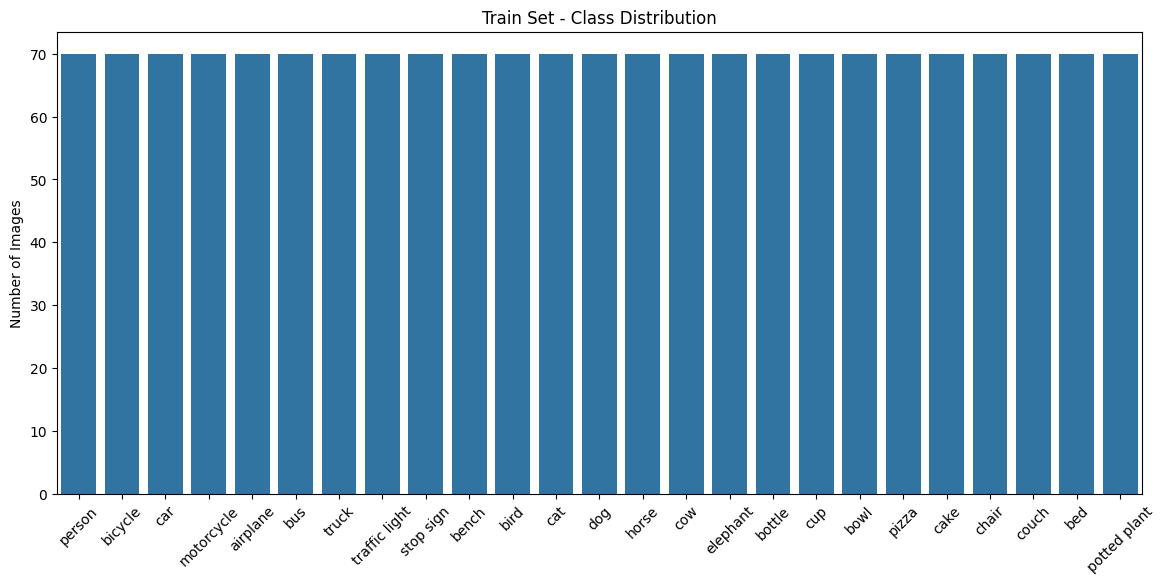

In [18]:
# %% Class distribution plot

classes = []
counts = []

for cls, data in metadata['classes'].items():
    classes.append(cls)
    counts.append(data['train'])

plt.figure(figsize=(14,6))
sns.barplot(x=classes, y=counts)
plt.xticks(rotation=45)
plt.title("Train Set - Class Distribution")
plt.ylabel("Number of Images")
plt.show()


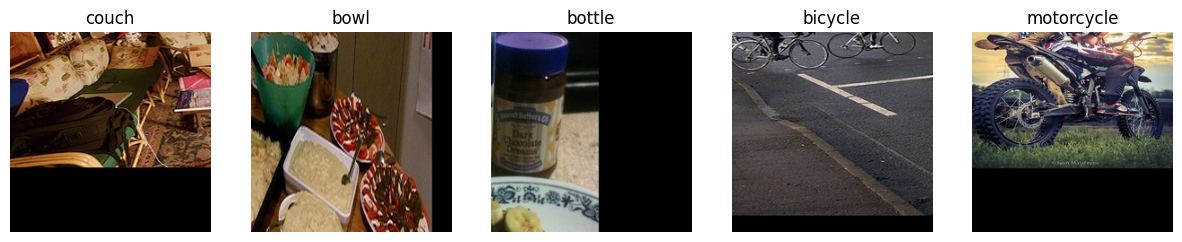

In [19]:
# %% Show random sample images

def show_samples(split="train", n=5):
    plt.figure(figsize=(15,5))
    i = 1
    for cls in random.sample(os.listdir(f"{BASE_DIR}/classification/{split}"), 5):
        img_path = os.path.join(
            BASE_DIR, "classification", split, cls,
            random.choice(os.listdir(f"{BASE_DIR}/classification/{split}/{cls}"))
        )
        img = Image.open(img_path)
        plt.subplot(1,5,i)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
        i += 1
    plt.show()

show_samples("train")


In [20]:
# %% STEP 8.0 PyTorch Setup

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🔥 Device:", device)

BASE_DIR = "smartvision_dataset/classification"
NUM_CLASSES = 25
BATCH_SIZE = 32
EPOCHS = 5


🔥 Device: cuda


In [21]:
# %% STEP 8.1 Data Transforms

train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(f"{BASE_DIR}/train", transform=train_tfms)
val_ds   = datasets.ImageFolder(f"{BASE_DIR}/val", transform=val_tfms)
test_ds  = datasets.ImageFolder(f"{BASE_DIR}/test", transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['airplane', 'bed', 'bench', 'bicycle', 'bird', 'bottle', 'bowl', 'bus', 'cake', 'car', 'cat', 'chair', 'couch', 'cow', 'cup', 'dog', 'elephant', 'horse', 'motorcycle', 'person', 'pizza', 'potted plant', 'stop sign', 'traffic light', 'truck']


In [22]:
# %% Training & Validation Loop

def train_model(model, optimizer, criterion, epochs, name):
    model.to(device)
    best_acc = 0
    history = {"train_acc":[], "val_acc":[]}

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0

        for imgs, labels in tqdm(train_loader, desc=f"{name} Train Epoch {epoch+1}"):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        history["train_acc"].append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"{name}_best.pth")

    print(f"✅ Best Val Accuracy ({name}): {best_acc:.4f}")
    return history


In [23]:
# %% VGG16

vgg = models.vgg16(pretrained=True)

for param in vgg.features.parameters():
    param.requires_grad = False

vgg.classifier[6] = nn.Linear(4096, NUM_CLASSES)

optimizer = optim.Adam(vgg.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

history_vgg = train_model(vgg, optimizer, criterion, EPOCHS, "VGG16")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 77.4MB/s]
VGG16 Train Epoch 1: 100%|██████████| 55/55 [00:16<00:00,  3.31it/s]


Epoch 1: Train Acc=0.3669 | Val Acc=0.3813


VGG16 Train Epoch 2: 100%|██████████| 55/55 [00:15<00:00,  3.53it/s]


Epoch 2: Train Acc=0.6617 | Val Acc=0.3840


VGG16 Train Epoch 3: 100%|██████████| 55/55 [00:15<00:00,  3.60it/s]


Epoch 3: Train Acc=0.7646 | Val Acc=0.4347


VGG16 Train Epoch 4: 100%|██████████| 55/55 [00:15<00:00,  3.59it/s]


Epoch 4: Train Acc=0.8320 | Val Acc=0.4320


VGG16 Train Epoch 5: 100%|██████████| 55/55 [00:15<00:00,  3.55it/s]


Epoch 5: Train Acc=0.8554 | Val Acc=0.4240
✅ Best Val Accuracy (VGG16): 0.4347


In [24]:
# %% ResNet50

resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, NUM_CLASSES)

optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)

history_resnet = train_model(resnet, optimizer, criterion, EPOCHS, "ResNet50")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 202MB/s]
ResNet50 Train Epoch 1: 100%|██████████| 55/55 [00:10<00:00,  5.24it/s]


Epoch 1: Train Acc=0.0869 | Val Acc=0.1093


ResNet50 Train Epoch 2: 100%|██████████| 55/55 [00:10<00:00,  5.20it/s]


Epoch 2: Train Acc=0.2429 | Val Acc=0.2853


ResNet50 Train Epoch 3: 100%|██████████| 55/55 [00:10<00:00,  5.25it/s]


Epoch 3: Train Acc=0.3680 | Val Acc=0.3387


ResNet50 Train Epoch 4: 100%|██████████| 55/55 [00:10<00:00,  5.11it/s]


Epoch 4: Train Acc=0.4783 | Val Acc=0.3600


ResNet50 Train Epoch 5: 100%|██████████| 55/55 [00:10<00:00,  5.04it/s]


Epoch 5: Train Acc=0.5229 | Val Acc=0.3387
✅ Best Val Accuracy (ResNet50): 0.3600


In [25]:
# %% MobileNetV2

mobilenet = models.mobilenet_v2(pretrained=True)

for param in mobilenet.features.parameters():
    param.requires_grad = False

mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, NUM_CLASSES)

optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=1e-4)

history_mobilenet = train_model(mobilenet, optimizer, criterion, EPOCHS, "MobileNetV2")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]
MobileNetV2 Train Epoch 1: 100%|██████████| 55/55 [00:08<00:00,  6.76it/s]


Epoch 1: Train Acc=0.0629 | Val Acc=0.1147


MobileNetV2 Train Epoch 2: 100%|██████████| 55/55 [00:08<00:00,  6.70it/s]


Epoch 2: Train Acc=0.1600 | Val Acc=0.2107


MobileNetV2 Train Epoch 3: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Epoch 3: Train Acc=0.2480 | Val Acc=0.2667


MobileNetV2 Train Epoch 4: 100%|██████████| 55/55 [00:08<00:00,  6.76it/s]


Epoch 4: Train Acc=0.3406 | Val Acc=0.2800


MobileNetV2 Train Epoch 5: 100%|██████████| 55/55 [00:08<00:00,  6.73it/s]


Epoch 5: Train Acc=0.3989 | Val Acc=0.3013
✅ Best Val Accuracy (MobileNetV2): 0.3013


In [26]:
# %% EfficientNetB0

efficientnet = models.efficientnet_b0(pretrained=True)

for param in efficientnet.features.parameters():
    param.requires_grad = False

efficientnet.classifier[1] = nn.Linear(
    efficientnet.classifier[1].in_features, NUM_CLASSES
)

optimizer = optim.Adam(efficientnet.classifier.parameters(), lr=1e-4)

history_eff = train_model(efficientnet, optimizer, criterion, EPOCHS, "EfficientNetB0")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]
EfficientNetB0 Train Epoch 1: 100%|██████████| 55/55 [00:08<00:00,  6.50it/s]


Epoch 1: Train Acc=0.0771 | Val Acc=0.0960


EfficientNetB0 Train Epoch 2: 100%|██████████| 55/55 [00:07<00:00,  7.07it/s]


Epoch 2: Train Acc=0.1714 | Val Acc=0.2373


EfficientNetB0 Train Epoch 3: 100%|██████████| 55/55 [00:07<00:00,  7.18it/s]


Epoch 3: Train Acc=0.2874 | Val Acc=0.2800


EfficientNetB0 Train Epoch 4: 100%|██████████| 55/55 [00:08<00:00,  6.72it/s]


Epoch 4: Train Acc=0.3869 | Val Acc=0.3387


EfficientNetB0 Train Epoch 5: 100%|██████████| 55/55 [00:08<00:00,  6.66it/s]


Epoch 5: Train Acc=0.4411 | Val Acc=0.3840
✅ Best Val Accuracy (EfficientNetB0): 0.3840


In [27]:
# %% Auto evaluation function

import time
import numpy as np

def evaluate_model(model, name):
    model.load_state_dict(torch.load(f"{name}_best.pth"))
    model.to(device)
    model.eval()

    correct, total = 0, 0
    inference_times = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            start = time.time()
            outputs = model(imgs)
            end = time.time()

            inference_times.append(end - start)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    avg_inference_time = np.mean(inference_times)

    return accuracy, avg_inference_time


In [28]:
# %% Run evaluation on all models

results = {}

results["VGG16"] = evaluate_model(vgg, "VGG16")
results["ResNet50"] = evaluate_model(resnet, "ResNet50")
results["MobileNetV2"] = evaluate_model(mobilenet, "MobileNetV2")
results["EfficientNetB0"] = evaluate_model(efficientnet, "EfficientNetB0")


In [29]:
# %% Print comparison

print("="*65)
print(f"{'Model':15s} | {'Accuracy':10s} | {'Inf Time (s)':12s}")
print("="*65)

for model, (acc, t) in results.items():
    print(f"{model:15s} | {acc*100:9.2f}% | {t:12.4f}")

print("="*65)


Model           | Accuracy   | Inf Time (s)
VGG16           |     40.53% |       0.0017
ResNet50        |     32.53% |       0.0062
MobileNetV2     |     32.00% |       0.0056
EfficientNetB0  |     21.60% |       0.0090


In [30]:
# %% Auto select best model

best_model = None
best_score = 0

print("\n📊 Model Scoring (Accuracy / Inference Time):\n")

for model, (acc, t) in results.items():
    score = acc / t
    print(f"{model:15s} → Score: {score:.4f}")

    if score > best_score:
        best_score = score
        best_model = model

print("\n" + "="*65)
print(f"🏆 BEST MODEL SELECTED AUTOMATICALLY: {best_model}")
print(f"🔥 Score: {best_score:.4f}")
print("="*65)



📊 Model Scoring (Accuracy / Inference Time):

VGG16           → Score: 238.0774
ResNet50        → Score: 52.8212
MobileNetV2     → Score: 57.1823
EfficientNetB0  → Score: 23.8760

🏆 BEST MODEL SELECTED AUTOMATICALLY: VGG16
🔥 Score: 238.0774


In [31]:
! pip install ultralytics opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.8 MB/s eta 0:00:0000:01


In [3]:
from ultralytics import YOLO
import os
from tqdm import tqdm


ModuleNotFoundError: No module named 'ultralytics'

In [33]:
BASE_DIR = "smartvision_dataset"
DET_IMG_DIR = f"{BASE_DIR}/detection/images"
DET_LBL_DIR = f"{BASE_DIR}/detection/labels"

os.makedirs(DET_IMG_DIR, exist_ok=True)
os.makedirs(DET_LBL_DIR, exist_ok=True)



In [34]:
SELECTED_CLASSES = {
    'person':0,'bicycle':1,'car':2,'motorcycle':3,'airplane':4,'bus':5,
    'truck':7,'traffic light':9,'stop sign':11,'bench':13,'bird':14,
    'cat':15,'dog':16,'horse':17,'cow':19,'elephant':20,'bottle':39,
    'cup':41,'bowl':45,'pizza':53,'cake':55,'chair':56,'couch':57,
    'bed':59,'potted plant':58
}

coco_to_yolo = {cid: i for i, cid in enumerate(SELECTED_CLASSES.values())}


In [35]:
# for img_idx, item in enumerate(tqdm(all_detection_data, desc="Creating YOLO dataset")):
#   img = item['image']
#   orig_w, orig_h = img.size # resize image to 640x640
#   # img_resized = img.resize((YOLO_SIZE, YOLO_SIZE))
#   img_name = f"image_{img_idx:06d}.jpg"
#   img_path = os.path.join(DET_IMG_DIR, img_name)
#   # img_resized.save(img_path, quality=95)
#   img.save(img_path, quality=95)

#   bboxes = item['annotations']['bbox']
#   categories = item['annotations']['category']
#   label_lines = []
#   scale_x = YOLO_SIZE / orig_w
#   scale_y = YOLO_SIZE / orig_h


#   for bbox, cat_id in zip(bboxes, categories):
#     if cat_id not in coco_to_yolo:
#       continue
#     x, y, w, h = bbox # COCO format
#     # # scale bbox
#     # x *= scale_x
#     # y *= scale_y
#     # w *= scale_x
#     # h *= scale_y
#      # normalize
#     x_center = (x + w / 2) / orig_w
#     y_center = (y + h / 2) / orig_h
#     w_norm = w / orig_w
#     h_norm = h / orig_h
#     # YOLO normalized
#     # x_center = (x + w/2) / YOLO_SIZE
#     # y_center = (y + h/2) / YOLO_SIZE
#     # w_norm = w / YOLO_SIZE
#     # h_norm = h / YOLO_SIZE
#     # IMPORTANT safety check
#     if 0 < x_center < 1 and 0 < y_center < 1:
#       label_lines.append(
#           f"{coco_to_yolo[cat_id]} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
#           )
#   if label_lines:
#         label_path = os.path.join(DET_LBL_DIR, img_name.replace(".jpg", ".txt"))
#         with open(label_path, "w") as f:
#           f.write("\n".join(label_lines))

In [36]:
for img_idx, item in enumerate(tqdm(all_detection_data, desc="Creating YOLO dataset")):

    img = item['image']
    orig_w, orig_h = img.size

    img_name = f"image_{img_idx:06d}.jpg"
    img_path = os.path.join(DET_IMG_DIR, img_name)
    img.save(img_path, quality=95)

    bboxes = item['annotations']['bbox']
    categories = item['annotations']['category']

    label_lines = []

    for bbox, cat_id in zip(bboxes, categories):

        if cat_id not in coco_to_yolo:
            continue

        x, y, w, h = bbox  # COCO format

        # ---- YOLO NORMALIZATION (correct) ----
        x_center = (x + w / 2) / orig_w
        y_center = (y + h / 2) / orig_h
        w_norm = w / orig_w
        h_norm = h / orig_h

        # ---- 🔥 IMPORTANT FILTERS 🔥 ----

        # 1️⃣ Remove tiny noisy boxes
        if w_norm < 0.02 or h_norm < 0.02:
            continue

        # 2️⃣ Clip safety (image ke bahar na jaaye)
        if not (0 < x_center < 1 and 0 < y_center < 1):
            continue

        label_lines.append(
            f"{coco_to_yolo[cat_id]} "
            f"{x_center:.6f} {y_center:.6f} "
            f"{w_norm:.6f} {h_norm:.6f}"
        )

    if label_lines:
        label_path = os.path.join(
            DET_LBL_DIR, img_name.replace(".jpg", ".txt")
        )
        with open(label_path, "w") as f:
            f.write("\n".join(label_lines))


Creating YOLO dataset: 100%|██████████| 2125/2125 [00:05<00:00, 373.02it/s]


In [37]:
yaml_text = f"""
path: {os.path.abspath(BASE_DIR)}/detection
train: images
val: images

nc: 25
names:
"""
for i, name in enumerate(SELECTED_CLASSES.keys()):
    yaml_text += f"  {i}: {name}\n"

with open(f"{BASE_DIR}/detection/data.yaml", "w") as f:
    f.write(yaml_text)


In [38]:
model = YOLO("yolov8s.pt")

model.train(
    data=f"{BASE_DIR}/detection/data.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    conf=0.01
)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=0.01, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=smartvision_dataset/detection/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2526.1±986.3 MB/s, size: 134.4 KB)
train: Scanning /content/smartvision_dataset/detection/labels... 2125 images, 0 backgrounds, 114 corrupt: 100% ━━━━━━━━━━━━ 2125/2125 2.2Kit/s 1.0s0.1s
train: /content/smartvision_dataset/detection/images/image_000043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1534      1.1256      1.1228      1.1566       1.317      1.1345       1.266      1.1246      1.0987       1.116      1.1141      1.1348      1.1596      1.2801      1.1323       1.378      1.1375      1.1353      1.1334      1.1303      1.1262]
train: /content/smartvision_dataset/detection/images/image_000044.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1534      1.1256      1.1228      1.1566       1.317      1.1345       1.266      1.1246      1.0987       1.116      1.1141      1.1348      1.1596      1.2801      1.1323       1.378    

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/10      4.88G       2.15      4.141      2.476         40        640: 100% ━━━━━━━━━━━━ 126/126 3.1it/s 41.0s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.5it/s 18.0s0.2s
                   all       2011      12823       0.39       0.33      0.315      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10      4.91G       1.78       2.39      2.039        109        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/10      4.92G      1.655      2.256      1.982         91        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 37.3s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.9it/s 16.0s0.3s
                   all       2011      12823      0.464      0.414      0.399      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10      4.94G      1.485      1.811      1.983        151        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/10      4.96G      1.528      1.918      1.852         63        640: 100% ━━━━━━━━━━━━ 126/126 3.5it/s 36.5s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.0it/s 15.9s0.2s
                   all       2011      12823      0.474      0.512      0.478      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/10      4.99G      1.455       1.61       1.79         94        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/10      4.99G      1.388      1.643      1.736         80        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 37.1s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.0it/s 15.8s0.2s
                   all       2011      12823      0.571      0.522      0.527      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/10      4.99G      1.382      1.516       1.74        112        640: 0% ──────────── 0/126  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/10      4.99G      1.279      1.444      1.651         60        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 36.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.1it/s 15.5s0.2s
                   all       2011      12823      0.646       0.56        0.6      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/10      4.99G      1.146      1.175      1.605        104        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/10      4.99G        1.2      1.294      1.582         87        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 36.8s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.1it/s 15.5s0.2s
                   all       2011      12823      0.698      0.621      0.664      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/10      4.99G      1.034      1.236      1.474         63        640: 0% ──────────── 0/126  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/10      4.99G      1.076       1.14      1.479         74        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 36.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.0it/s 15.7s0.2s
                   all       2011      12823      0.763      0.644      0.713      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/10      4.99G     0.9727      1.005      1.412         75        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 37.0s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.9it/s 16.2s0.3s
                   all       2011      12823      0.806      0.701      0.752      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/10      4.99G     0.9592      1.008       1.33        112        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/10      4.99G     0.9237     0.9385      1.372        125        640: 100% ━━━━━━━━━━━━ 126/126 3.5it/s 36.5s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.9it/s 16.0s0.2s
                   all       2011      12823      0.804      0.696      0.762      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/10      4.99G     0.9259      1.025      1.337         67        640: 0% ──────────── 0/126  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/10      4.99G     0.8459     0.8506       1.31         64        640: 100% ━━━━━━━━━━━━ 126/126 3.4it/s 36.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 4.1it/s 15.5s0.2s
                   all       2011      12823      0.849      0.717      0.781      0.425

10 epochs completed in 0.150 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 22.5MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,135,259 parameters, 0 gradients, 28.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 63/63 3.6it/s 17.6s0.3s
                   all       2011      12823      0.851      0.716       0.78      0.425
                person   

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79dedb084470>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,  

In [2]:
model = YOLO("runs/detect/train/weights/best.pt")

image_path = f"{BASE_DIR}/detection/images/image_000002.jpg"

# results = model(image_path, conf=0.05, save=True)
results = model(
    image_path,
    conf=0.35,      # confidence filter
    iou=0.5,        # overlapping boxes merge
    max_det=15,     # ek image me limit
    save=True
)


res = results[0]
res.show()

print(res.boxes)


NameError: name 'YOLO' is not defined

In [40]:
metrics = model.val()
# print(metrics.results_dict)


Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2679.0±838.0 MB/s, size: 128.0 KB)
val: Scanning /content/smartvision_dataset/detection/labels.cache... 2125 images, 0 backgrounds, 114 corrupt: 100% ━━━━━━━━━━━━ 2125/2125 4.3Mit/s 0.0s0s
train: /content/smartvision_dataset/detection/images/image_000043.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1534      1.1256      1.1228      1.1566       1.317      1.1345       1.266      1.1246      1.0987       1.116      1.1141      1.1348      1.1596      1.2801      1.1323       1.378      1.1375      1.1353      1.1334      1.1303      1.1262]
train: /content/smartvision_dataset/detection/images/image_000044.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1534      1.1256      1.1228      1.1566       1.317      1.1345       1.266      1.1246      1.0987       1.116      1.1141  

In [41]:
for i in metrics.results_dict:
    print(i," : ",f'{metrics.results_dict[i]:.3f}')


metrics/precision(B)  :  0.853
metrics/recall(B)  :  0.718
metrics/mAP50(B)  :  0.770
metrics/mAP50-95(B)  :  0.405
fitness  :  0.405


In [42]:
! pwd

/content


In [43]:
! ls /content/runs/detect/train/weights

best.pt  last.pt


In [1]:
from huggingface_hub import login,upload_file
import streamlit as st

# Step 1: Login
login(token=st.secrets['HuggingFace_token'])

upload_file(
    path_or_fileobj=r"D:\Smartvisionnew\VGG16_best.pth",
    path_in_repo="VGG16_best.pth",
    repo_id="jgvghf/smartvision",
    repo_type="model"
)


d:\Smartvisionnew\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing Files (1 / 1): 100%|██████████|  537MB /  537MB,  665kB/s  
New Data Upload: 100%|██████████|  521MB /  521MB,  665kB/s  


CommitInfo(commit_url='https://huggingface.co/jgvghf/smartvision/commit/f0854168295e5ffca2e7d82ff40a6cd345a7f92b', commit_message='Upload VGG16_best.pth with huggingface_hub', commit_description='', oid='f0854168295e5ffca2e7d82ff40a6cd345a7f92b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jgvghf/smartvision', endpoint='https://huggingface.co', repo_type='model', repo_id='jgvghf/smartvision'), pr_revision=None, pr_num=None)

In [2]:
from huggingface_hub import login,upload_file
import streamlit as st

# Step 1: Login
login(token=st.secrets['HuggingFace_token'])

upload_file(
    path_or_fileobj=r"D:\Smartvisionnew\best.pt",
    path_in_repo="best.pt",
    repo_id="jgvghf/smartvision",
    repo_type="model"
)


Processing Files (1 / 1): 100%|██████████| 22.5MB / 22.5MB,  566kB/s  
New Data Upload: 100%|██████████| 22.5MB / 22.5MB,  566kB/s  


CommitInfo(commit_url='https://huggingface.co/jgvghf/smartvision/commit/fdd24da5095743a13784a44efe3f0c6016af0d54', commit_message='Upload best.pt with huggingface_hub', commit_description='', oid='fdd24da5095743a13784a44efe3f0c6016af0d54', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jgvghf/smartvision', endpoint='https://huggingface.co', repo_type='model', repo_id='jgvghf/smartvision'), pr_revision=None, pr_num=None)